In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score, accuracy_score, roc_curve
from random import randint
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import re 
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from scipy import stats
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
from IPython.display import display, HTML, Latex
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import re
import math
from IPython.display import display, HTML, Latex
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from datetime import *
import datetime


## Prepare dataframe
- print data frame to see all the content, the answers and the columns
- print column names

In [2]:
classroom = pd.read_csv('/Users/konstantinoskevopoulos/Downloads/ODI-2023.csv', sep=';', on_bad_lines='skip')
df = pd.DataFrame(classroom)
df_modified = pd.DataFrame()

print(df)
print(df.columns.values)


           Tijdstempel    What programme are you in?  \
0    4-4-2023 12:08:33                  Masters - AI   
1    4-4-2023 12:08:36       Artificial Intelligence   
2    4-4-2023 12:08:38                            AI   
3    4-4-2023 12:08:52                   Data mining   
4    4-4-2023 12:08:59  Quantitative Risk Management   
..                 ...                           ...   
300  4-4-2023 12:13:33                     Exchange    
301  4-4-2023 12:13:42                Bioinformatics   
302  4-4-2023 12:14:42                            AI   
303  4-4-2023 12:16:05                            AI   
304  4-4-2023 12:28:06                 Econometrics    

    Have you taken a course on machine learning?  \
0                                            yes   
1                                             no   
2                                             no   
3                                            yes   
4                                             no   
..             

## Stress level cleaning
- Only take positive numbers between 0-100
- The rest is invalid (None)
- Replace invalids with the mean

The invalid stress level (values from 0-100) entries (a total of 19), are:
['-100', '106', '999', '4274', '990.000.001', '100 always', '101', '65?', '-5', '1E+11', nan, '-420', 'At this moment my stress level is 21', '200', 'What grazia said', 'Np.inf', 'Inf ', 'solid 0.2', 'it is what it is']


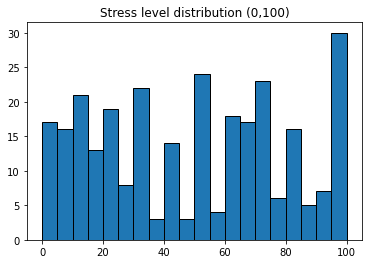

In [3]:
# stress level investigation
stress_level = df['What is your stress level (0-100)?']

# print(df['What is your stress level (0-100)?'].values)
stress_level = pd.to_numeric(stress_level, errors='coerce')
invalid_stress_level = stress_level[~((stress_level >= 0) & (stress_level <= 100))]
stress_level = np.where((stress_level >= 0) & (stress_level <= 100), stress_level, np.nan)

# Get the indices of invalid entries
invalid_indices_stress = invalid_stress_level.index

invalid_entries = []
for invalid_index in invalid_indices_stress:
    invalid_entries.append(df.loc[invalid_index,'What is your stress level (0-100)?'])

print('The invalid stress level (values from 0-100) entries (a total of %i), are:'%(len(invalid_entries)))
print(invalid_entries)

stress_level_valid = [item for item in stress_level if item is not None]

plt.title('Stress level distribution (0,100)')
plt.hist(stress_level_valid, bins=20, edgecolor='black')
plt.show()


# Replace NaNs with mean
mean_value = np.nanmean(stress_level)
mask = np.isnan(stress_level)
stress_level[mask] = mean_value

df['What is your stress level (0-100)?'] = stress_level

## Gender investigation

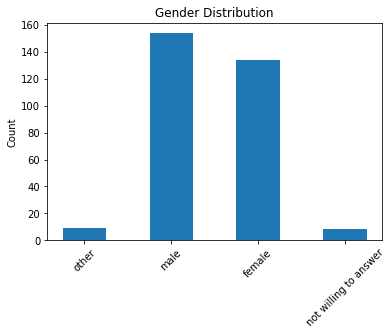

In [4]:
#Visualise the "gender" feature
gender = df['What is your gender?']

category_mapping = {'male': 'male', 'female': 'female', 'not willing to answer': 'not willing to answer'}

# Use the map function to map values to their respective categories, and replace other values with 'other'
gender_category = gender.map(category_mapping).fillna('other')

df['What is your gender?'] = gender

categories = ['male', 'female', 'not willing to answer', 'other']

bin_edges = [-0.5, 0.5, 1.5, 2.5, 3.5]

categories = gender_category.unique()
bin_edges = np.arange(len(categories) + 1) - 0.5

# Create a histogram
plt.hist(gender_category, bins=bin_edges, align='mid', rwidth=0.5)
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.xticks(range(len(categories)), categories, rotation=45)  # Set custom x-ticks with rotation
plt.show()

## How many students in room estimate, cleaning
- Only values larger than 0 and smaller than 2000, since this is not a realistic estimate
- Only extract numerical values from strings if present i.e. 'Around 200' becomes '200' which can be converted to float
- Any other entry is invalid and is considered nan
- Replace invalids with the mean

problem: 'six hundred' is also invalid as it is not a nummerical value

The invalid entries were (a total of 4)
['-6382', 'six hundred', 'Over 9000', 'Bout six hunnid']


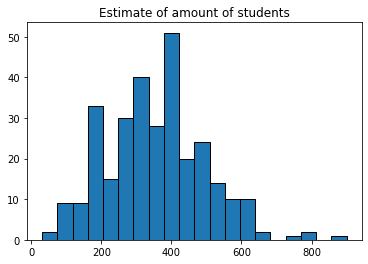

0


In [5]:
students_estimate = df['How many students do you estimate there are in the room?']

# Extract numerical value from students_estimate column
pattern = r'(-?\d+)'   # pattern to match one or more digits, excluding values starting with a negative sign
students_estimate = students_estimate.str.extract(pattern, expand=False)  # extract first match

# Convert extracted values to numeric
students_estimate = pd.to_numeric(students_estimate, errors='coerce')

# Create a boolean mask for valid values
mask = students_estimate.notna()  # Check for not NaN
mask &= students_estimate >= 0  # Check for greater than or equal to 0, excluding negative values
mask &= students_estimate <= 2000  # Check for less than or equal to 2000


# Use the boolean mask to set invalid values to NaN
students_estimate[~mask] = None

# Convert to list
students_estimate_list = students_estimate.values.tolist()

# Check for NaN values in students_estimate_list
nan_values = np.isnan(students_estimate_list)

# Get indices of NaN values
invalid_indices_students_estimate = [i for i, is_nan in enumerate(nan_values) if is_nan]
invalid_entries_students_estimate = []
for invalid_index in invalid_indices_students_estimate:
    invalid_entries_students_estimate.append(df.loc[invalid_index,'How many students do you estimate there are in the room?'])

print('The invalid entries were (a total of %i)'%(len(invalid_entries_students_estimate)))
print(invalid_entries_students_estimate)

plt.title('Estimate of amount of students')
plt.hist(students_estimate_list, bins=20, edgecolor='black')
plt.show()


# Training set
df['How many students do you estimate there are in the room?'] = students_estimate_list

#Making a training set out of 200 values in the stress level column, dropping NaNs
training_set = df['How many students do you estimate there are in the room?'].dropna()
training_set=training_set[200:]

# Create the KNN imputer and fit it on the training set
knn_imputer = KNNImputer(n_neighbors=30)
knn_imputer.fit(np.array(training_set).reshape(-1, 1))

# Impute missing values using the trained imputer
students_estimate = knn_imputer.transform(df['How many students do you estimate there are in the room?'].values.reshape(-1, 1))


df['How many students do you estimate there are in the room?'] = students_estimate
print(len(df[df['How many students do you estimate there are in the room?'].isna()]))



## Random number, cleaning
- remove dots
- replace commas by doys
- pi and π is accepted
- person with 1E152 is omitted
- then every entry is converted to a number if it's possible after the modifications
- replace NaNs with new random number with the median amount of digits

The invalid entries were (a total of 7)
['Random number', 'Driehonderd ', 'No', 'RandomStream RNG, RNG.nextInt()', 'Random()', '###############################################################################################################################################################################################################################################################', '|']


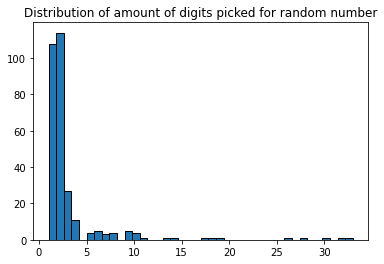

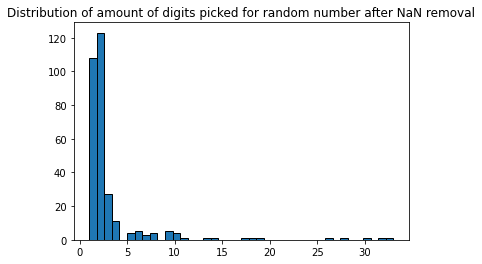

In [6]:
random_number = df['Give a random number']

random_number = random_number.str.replace('.', '')
random_number = random_number.str.replace(',', '.')
random_number = random_number.str.replace('π', '3.141592')
random_number = random_number.str.replace('pi', '3.141592')
random_number = pd.to_numeric(random_number, errors='coerce')

random_number_list = random_number.tolist()
# Check for NaN values
nan_values = pd.isna(random_number_list)

# Get indices of NaN values
invalid_indices_random_number = [i for i, is_nan in enumerate(nan_values) if is_nan]
invalid_entries_random_number = []
for invalid_index in invalid_indices_random_number:
    invalid_entries_random_number.append(df.loc[invalid_index,'Give a random number'])

print('The invalid entries were (a total of %i)'%(len(invalid_entries_random_number)))
print(invalid_entries_random_number)

random_number_digits = []
for rand in random_number_list:
    if not np.isnan(rand):
        if rand > 3.141 and rand < 3.143:
             random_number_digits.append(1)
        else:
            random_number_digits.append(len(str(int(rand))))
    else:
        random_number_digits.append(np.nan)
        
        
random_number_digits = np.array(random_number_digits)
random_number_digits = np.where((random_number_digits < 40) & (~np.isnan(random_number_digits)), random_number_digits, np.nan)


plt.title('Distribution of amount of digits picked for random number')
plt.hist(random_number_digits, bins=40 ,edgecolor='black')
plt.show()


# Replace NaNs with new random numbers with the same amount of digits as the median amount
median_amount_of_digits = np.nanmedian(random_number_digits)

def random_with_N_digits(n):
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)

for i, rand in enumerate(random_number):
    if np.isnan(rand):
        new_random_number = random_with_N_digits(int(median_amount_of_digits))
        random_number[i] = new_random_number
        
for i, digits in enumerate(random_number_digits):
    if np.isnan(digits):
        random_number_digits[i] = int(median_amount_of_digits)
      
      
# visualise the data
plt.title('Distribution of amount of digits picked for random number after NaN removal')
plt.hist(random_number_digits, bins=40 ,edgecolor='black')
plt.show()

    
df['Give a random number'] = random_number
df['Digits random number'] = random_number_digits


## Bed time last night
- Includes all sorts of time formats
- Converts AM/PM to 24 hour time
- Converts everything to double digits hh:mm time format
- Converts times from 7-11, and adds 12 such that 11 becomes 23, which is a more realistic bed time then 11 AM

problem: can't yet extract from 'around 5:30' to get '05:30', or '23u' to get '23:00'


The invalid entries were (a total of 13)
['7：00', 'after midnight', 'around 5:30', '23u', '11,1', 'Did not slept on the couch', 'When the moon was at the highest point', '4 hours', 'half past twelve', 'I went to bed at 1', 'I didnt ', 'Non of ya business', 'after your dad went ']


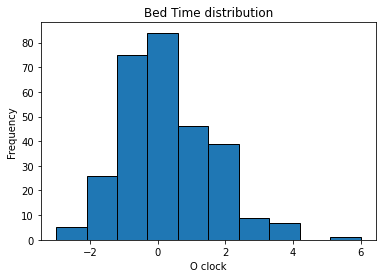

Mean bedtime:  00:19


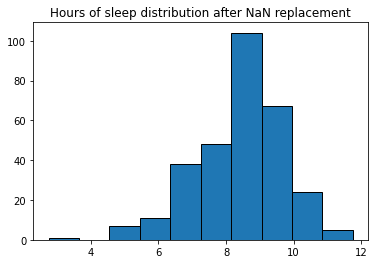

In [7]:
bed_time = df['Time you went to bed Yesterday']

# print(bed_time.tolist())

# Replace dots with colons at the beginning of time values
bed_time = bed_time.str.replace('.', ':', regex=True)

# Replace spaces with empty string
bed_time = bed_time.str.replace(' ', '', regex=True)


# Define a regex pattern to match time in hh:mm or h:mm format, or "around" followed by time in hh:mm or h:mm format
time_pattern = r'\b\d{1,2}:\d{2}\s*(?:[AaPp][Mm])?\b|\baround\s*(\d{1,2}:\d{2}\s*[AaPp][Mm])\b'

# Define a callback function to replace the matched time values
def replacer(match):
    time_str = match.group(0)
    if len(time_str) > 7:
        # Replace dots with colons at the beginning of time values
        time_str = time_str.replace('.', ':')
        # Replace spaces with empty string
        time_str = time_str.replace(' ', '')
    return time_str

# Use regex to find and replace all occurrences of time in the Series
bed_time = bed_time.str.replace(time_pattern, replacer, regex=True)


# Convert all uppercase letters to lowercase
bed_time = bed_time.str.lower()

# Replace 'midnight' with '00:00'
bed_time = bed_time.str.replace('midnight', '00:00', regex=True)

# Replace 'late' with '00:00'
bed_time = bed_time.str.replace('late', '00:00', regex=True)

# Replace 'noon' with '12:00 PM'
bed_time = bed_time.str.replace('noon', '12:00 PM', regex=True)

# Replace single-digit integers with hh:00 format, excluding cases followed by 'am' or 'pm' or a digit or a colon
bed_time = bed_time.str.replace(r'(?<!\d)(\d{1})(?!\d|[aApP][mM])', lambda x: '0' + x.group(1) + ':', regex=True)

# Replace other non-sense values with NaN
bed_time = bed_time.replace(['^.*[^0-9:\sAaPpMm].*$', '^.{0,1}$'], np.nan, regex=True)

# Convert remaining missing values to NaN
bed_time = bed_time.fillna(np.nan)



# Extract the hour and minute parts from the cleaned time values
hour_part = bed_time.str.extract(r'(\d{1,2})\s*:?\s*(\d{2})?')[0].str.zfill(2)
minute_part = bed_time.str.extract(r'(\d{1,2})\s*:?\s*(\d{2})?')[1].fillna('00')

# Concatenate the hour and minute parts with a colon to form HH:MM format
bed_time = hour_part + ':' + minute_part


# Access elements that are not NaN and change '24:00' and '12:00' to '00:00'
bed_time = bed_time.apply(lambda x: '00' + x[2:] if pd.notna(x) and x == '24:00' else x)
for tens in range(6):
    for mins in range(10):
        bed_time = bed_time.apply(lambda x: '00' + x[2:] if pd.notna(x) and x == f'12:{tens}{mins}' else x)
# Access elements that are not NaN and change everything between'7:00' and '11:00' to 'HH + 12:00', so 11 becomes 23
bed_time = bed_time.apply(lambda x: str(int(x[:2]) + 12) + x[2:] if pd.notna(x) and x[:2] in ['07', '08', '09', '10', '11'] else x)

# Reset the index of the cleaned 'bed_time' column
bed_time = bed_time.reset_index(drop=True)

bed_time_list = bed_time.tolist()
# print(bed_time_list)


# Check for NaN values
nan_values = pd.isna(bed_time_list)

# Get indices of NaN values
invalid_indices_bed_time = [i for i, is_nan in enumerate(nan_values) if is_nan]
invalid_entries_bed_time = []
for invalid_index in invalid_indices_bed_time:
    invalid_entries_bed_time.append(df.loc[invalid_index,'Time you went to bed Yesterday'])

print('The invalid entries were (a total of %i)'%(len(invalid_entries_bed_time)))
print(invalid_entries_bed_time)



# Convert nan to 'NaN'
bed_time_list = ['NaN' if isinstance(x, float) and np.isnan(x) else x for x in bed_time_list]

# Extract hour component from bedtime list, ignoring 'NaN' values
hour_list = []
for time in bed_time_list:
    if time != 'NaN':
        try:
            hour = int(time.split(':')[0])
            if hour >= 20 and hour <=24:
                hour = hour-24
            hour_list.append(hour)
        except ValueError:
            pass


# Create two histograms with overlapping bins
plt.hist(hour_list, bins = 10, edgecolor='black')
plt.xlabel('O clock')
plt.ylabel('Frequency')
plt.title('Bed Time distribution')
plt.show()



# Find mean bed time
bedtime_radians = []
for bedtime in bed_time_list:
    if bedtime != 'NaN':
        if bedtime == '24:00':
            bedtime = '00:00'
        hours, minutes = map(int, bedtime.split(':'))
        total_minutes = hours * 60 + minutes
        bedtime_radians.append(2 * np.pi * total_minutes / (24 * 60))

# Calculate circular mean bedtime in radians
mean_radian = np.arctan2(sum(np.sin(rad) for rad in bedtime_radians), sum(np.cos(rad) for rad in bedtime_radians))

# Convert circular mean bedtime back to hours and minutes
mean_minutes = int(24 * 60 * mean_radian / (2 * np.pi))
mean_hours = int(mean_minutes // 60)
mean_minutes = int(mean_minutes % 60)

# Format mean bedtime as string in HH:MM format
mean_bedtime_string = '{:02d}:{:02d}'.format(mean_hours, mean_minutes)

print("Mean bedtime: ", mean_bedtime_string)


# Replace 'NaN' with mean bedtime in bed_time_list
bed_time_list = [mean_bedtime_string if bedtime == 'NaN' else bedtime for bedtime in bed_time_list]
df_modified['Bed time yesterday'] = bed_time_list



# Get Hours of sleep assuming wake up time is '08:45'
# Assumed wake-up time
wake_up_hour = 8
wake_up_minute = 45
wake_up_time = datetime.time(hour=wake_up_hour, minute=wake_up_minute)

# Convert bedtime values to datetime.time objects
bedtime_objects = []
for bedtime in bed_time_list:
    hours, minutes = map(int, bedtime.split(':'))
    bedtime_objects.append(datetime.time(hour=hours, minute=minutes))

# Calculate hours of sleep by subtracting wake-up time from bedtime
hours_of_sleep_list = []
for bedtime in bedtime_objects:
    current_date = datetime.date.today()  # Use current date
    sleep_start = datetime.datetime.combine(current_date, bedtime)
    sleep_end = datetime.datetime.combine(current_date, wake_up_time)

    if sleep_start > sleep_end:
        # If sleep_start is after sleep_end, it means the bedtime is after wake-up time,
        # indicating that the bedtime is on the previous day
        sleep_start -= datetime.timedelta(days=1)

    sleep_duration = sleep_end - sleep_start
    hours_of_sleep = sleep_duration.seconds / 3600

    hours_of_sleep_list.append(hours_of_sleep)

df['Time you went to bed Yesterday'] = hours_of_sleep_list


plt.hist(hours_of_sleep_list, edgecolor='black')
plt.title('Hours of sleep distribution after NaN replacement')
plt.show()

## Hours per week sport cleaning:
- Entry should be between 0-168 hours (there aren't more than 168 hours in a week)
- Fractions are rounded automatically
- Extract numerical values from strings with text so 3h counts as 3
- Anything that doesn't apply to these rules is invalid and takes value NaN
- Replace invalids with the mean

Problem: Y = 5x counts as 5

The invalid entries were (a total of 5)
['Nadda ', '290', 'h', 'Np.nan ', 'depends on how many hours I spent with your mom']


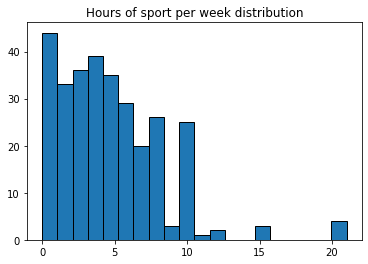

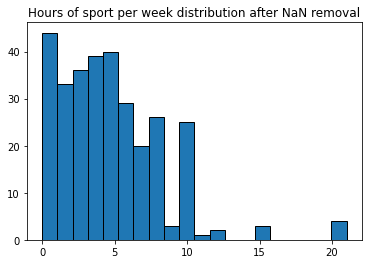

In [8]:
sport = df['How many hours per week do you do sports (in whole hours)? ']

# Use regular expression to extract numerical value
pattern = r'(\d+)'  # pattern to match one or more digits
sport = sport.str.extract(pattern, expand=False)  # extract first match

# Convert extracted values to numeric
sport = pd.to_numeric(sport, errors='coerce')

# Create a boolean mask for valid values
mask = (sport.notna()) & (sport >= 0) & (sport <= 168)

# Use the boolean mask to set invalid values to NaN
sport[~mask] = None

# Convert to list
sport_list = sport.values.tolist()

invalid_sport = sport[~((sport >= 0) & (sport <= 168))]

# Get the indices of invalid entries
invalid_indices_sport = invalid_sport.index

invalid_entries_sport = []
for invalid_index in invalid_indices_sport:
    invalid_entries_sport.append(df.loc[invalid_index, 'How many hours per week do you do sports (in whole hours)? '])

print('The invalid entries were (a total of %i)'%(len(invalid_entries_sport)))
print(invalid_entries_sport)

plt.title('Hours of sport per week distribution')
plt.hist(sport_list, bins=20, edgecolor='black')
plt.show()



# Replace NaNs with mean
mean_value = np.nanmean(sport)
mask = np.isnan(sport)
sport[mask] = mean_value

plt.title('Hours of sport per week distribution after NaN removal')
plt.hist(sport, bins=20, edgecolor='black')
plt.show()

df['How many hours per week do you do sports (in whole hours)? '] = sport


##  Cleaning the date of birth 
### and convert that feature to the actual age of the individual 

In [9]:
#Cleaning day-month-year with day/month/year
for num, val in enumerate(df['When is your birthday (date)?']):        
    if len(val)>=10:
        if "-" in val:
            val = val.replace("-","/")
            df['When is your birthday (date)?'][num] = val
            
        if "." in val:
            val = val.replace(".","/")
            df['When is your birthday (date)?'][num] = val
        
        if " " in val:
            val = val.replace(" ","/")
            df['When is your birthday (date)?'][num] = val
    
        el = val.split('/')
        if len(el) != 3:
            df['When is your birthday (date)?'][num] = 'NaN'
            
        if df['When is your birthday (date)?'][num] != 'NaN':
            if len(el[2]) > 4:
                df['When is your birthday (date)?'][num] = 'NaN'
            if len(el[0]) == 4 and len(el[2])!= 4:
                temp = el[2] 
                el[2] = el[0]
                el[0] = temp


        if val=='00/00/0000':
            val = "NaN"
            df['When is your birthday (date)?'][num] = val
    else:
        df['When is your birthday (date)?'][num] = 'NaN'
# Calculate - Derive the age from the date of birth        
for num, val in enumerate(df['When is your birthday (date)?']):  
    el = val.split('/')
    if len(el[0]) == 4 and len(el[2])!= 4:
            temp = el[2] 
            el[2] = el[0]
            el[0] = temp
            val = "/".join(el)
            df['When is your birthday (date)?'][num] = "/".join(el)
    if num != 14:
        if df['When is your birthday (date)?'][num] != 'NaN':
            df['When is your birthday (date)?'][num] = 2023 - int(val.split('/')[2])
    else:
        df['When is your birthday (date)?'][num] = 'NaN'
    if num == 268:
        df['When is your birthday (date)?'][num] = 22
pd.options.display.max_rows = 306



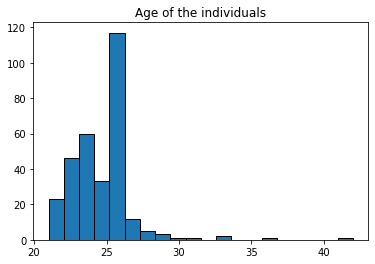

In [10]:
# Visualise the distribution of age
count = 0
vals = 0
for num, val in enumerate(df['When is your birthday (date)?']): 
    if df['When is your birthday (date)?'][num] != 'NaN':
        count += 1 
        vals += df['When is your birthday (date)?'][num]
avg = vals/count 
for num, val in enumerate(df['When is your birthday (date)?']):  
    if df['When is your birthday (date)?'][num] == 'NaN' or df['When is your birthday (date)?'][num] > 80:
        df['When is your birthday (date)?'][num] = avg
        
age_list = df['When is your birthday (date)?']
plt.hist(age_list, bins=20, edgecolor='black')
plt.title('Age of the individuals')
plt.show()


In [11]:
# Feature engineering
# Remove redundant columns and combine them into one
# Create the "digits of random number" feature
df['Relevant Background?'] = (df['Have you taken a course on machine learning?'] == 'yes') | (df['Have you taken a course on information retrieval?'] == 1) | (df['Have you taken a course on statistics?'] == 'mu') | (df['Have you taken a course on databases?'] == 'ja')
df['Relevant Background?'] = (df['Relevant Background?'] == True).astype(int)
df.drop('Have you taken a course on machine learning?', axis=1, inplace=True)
df.drop('Have you taken a course on information retrieval?', axis=1, inplace=True)
df.drop('Have you taken a course on statistics?', axis=1, inplace=True)
df.drop('Have you taken a course on databases?', axis=1, inplace=True)
df.drop('Give a random number', axis=1, inplace=True)

In [12]:
# Remove the 'Tijdstempel' column and rename the columns of the dataframe
df.drop('Tijdstempel', axis=1, inplace=True)
df.columns = ['Programme', 'Gender', 'ChatGPT use in assignments', 'Age', 'Estimation of students in the room', 'Did you stand up to come to your previous answer ?', 'Stress Level', 'Hours per week of sports activities', 'Hours of sleeping last night', 'Good day for you 1', 'Good day for you 2', 'Digits of random number', 'Relevant background?']

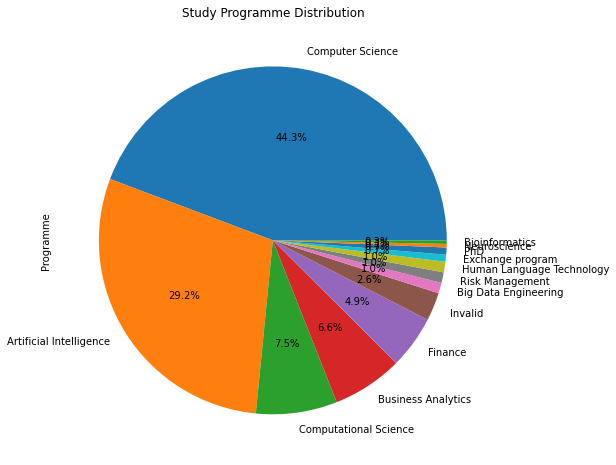

In [13]:
# Feature Engineering - make values integers
df['Estimation of students in the room'] = df['Estimation of students in the room'].astype(int)
df['Hours per week of sports activities'] = df['Hours per week of sports activities'].astype(int)
df['Digits of random number'] = df['Digits of random number'].astype(int)
df['Stress Level'] = df['Stress Level'].astype(int)
df['Stress Level Discr.'] = df['Stress Level']
# Discretise-categorise the "Stress Levels" feature
for num, val in enumerate(df['Stress Level']):
    if df['Stress Level'][num] <= 70:
        df['Stress Level Discr.'][num] = 'Manageable'
    else:
        df['Stress Level Discr.'][num] = 'Very High'
        
# clean the programme column 
for num, val in enumerate(df['Programme']):
    if re.search(r'\d', df['Programme'][num]):
        df['Programme'][num] = 'Invalid'
    if 'AI' in df['Programme'][num] or 'Artificial' in df['Programme'][num] or 'Intelligence' in df['Programme'][num] or 'Ai' in df['Programme'][num]:
        df['Programme'][num] = 'Artificial Intelligence'
    elif 'Computational' in df['Programme'][num] or 'CLS' in df['Programme'][num] or 'computational'in df['Programme'][num]:
        df['Programme'][num] = 'Computational Science'
    elif 'CS' in df['Programme'][num] or 'cs' in df['Programme'][num] or 'computer' in df['Programme'][num] or 'Computer' in df['Programme'][num]:
        df['Programme'][num] = 'Computer Science'
    elif 'Bio' in df['Programme'][num] or 'bio' in df['Programme'][num]:
        df['Programme'][num] = 'Bioinformatics'
    elif 'med' in df['Programme'][num]:
        df['Programme'][num] = 'Biomedical Science'
    elif 'metrics' in df['Programme'][num]:
        df['Programme'][num] = 'Econometrics'
    elif 'fin' in df['Programme'][num] or 'Finance'in df['Programme'][num] or 'QRM'in df['Programme'][num]:
        df['Programme'][num] = 'Finance'
    elif 'risk' in df['Programme'][num] or 'Risk'in df['Programme'][num]:
        df['Programme'][num] = 'Risk Management'
    elif 'Business' in df['Programme'][num] or 'business'in df['Programme'][num] or 'BA'in df['Programme'][num] or 'ba'in df['Programme'][num]:
        df['Programme'][num] = 'Business Analytics'
    elif 'PhD' in df['Programme'][num] or 'phd' in df['Programme'][num]:
        df['Programme'][num] = 'PhD'
    elif 'Human'in df['Programme'][num] or 'human'in df['Programme'][num]:
        df['Programme'][num] = 'Human Language Technology'
    elif 'exchange'in df['Programme'][num] or 'Exchange' in df['Programme'][num]:
        df['Programme'][num] = 'Exchange program'
    elif 'neuro' in df['Programme'][num] or 'Neuro' in df['Programme'][num]:
        df['Programme'][num] = 'Neuroscience'
    elif 'data' in df['Programme'][num] or 'Data' in df['Programme'][num]:
        df['Programme'][num] = 'Big Data Engineering'
    else:
        df['Programme'][num] = 'Invalid'
programme_count = df['Programme'].value_counts()
plt.figure(figsize=(10,8))
programme_count.plot(kind='pie', autopct='%1.1f%%')
plt.title('Study Programme Distribution')
plt.show()

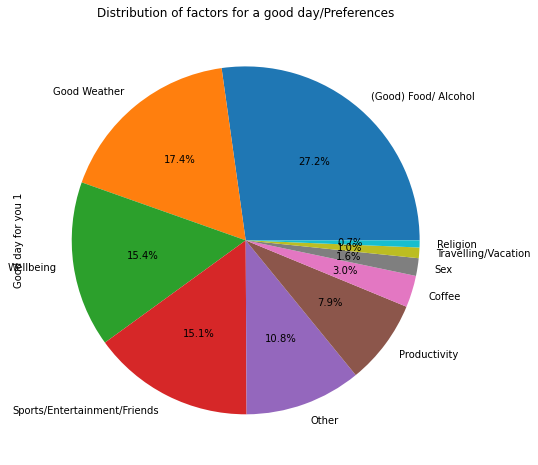

In [14]:
# Clean the column "What makes a good day for you" and remove the one of the two identical columns 
df.drop('Good day for you 2', axis=1, inplace=True)
food = ['food', 'Food', 'eten', 'chocolate', 'eat', 'Eat', 'meal', 'Meal', 'beer', 
        'bread', 'breakfast', 'Breakfast', 'Beer', 'toast', 'Toast', 'snacks', 'Snacks', 'Pancakes']
sports_entertainment_friends = ['sport', 'Sport', 'win', 'Win', 'game', 'gym', 'train', 
                                'Train', 'movie', 'music', 'friend', 'Friend', 'peop', 
                                'Peop', 'Gym', 'Music', 'yoga','outside', 'exerc', 
                                'Exerc', 'game', 'fun', 'Fun', 'outisde']
sex = ['sex', 'Sex']
religion = ['bible', 'Bible', 'prayer', 'Prayer']
weather = ['sun', 'Sun', 'weather', 'Weather', 'sky', 'Sky', 'skie', 'air', 'Ski']
productivity_grades = ['product', 'Product', 'code', 'done', 'work', 'Work', 'grade', 'Grade', 'data', 
                       'Data','results', 'progress', 'Progress']
coffee = ['coffee', 'Coffee']
wellbeing = ['stress', 'no', 'Netflix', 'free', 'love', 'nice', 'Nice', 'mood',
             'rest', 'Rest', 'sleep', 'Sleep', 'hour', 'Hour', 'wake up', 'week', 
             'Week', 'relax', 'Relax', 'No', 'family', 'Family', 'well', 'Well', 'off', 'Off', 'Mood', 'Free']
travel =['Holiday', 'holiday', 'vacat', 'Vacat']
def find(category, large_string):
    found = False
    for s in category:
        if s in large_string:
            found = True
            break

    if found:
        find_var = True
    else:
        find_var = False
    
    return find_var
# Categorise the answers given by participants    
for num, val in enumerate(df['Good day for you 1']):
    if find(food, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = '(Good) Food/ Alcohol'
    elif find(sports_entertainment_friends, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Sports/Entertainment/Friends'
    elif find(sex, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Sex'
    elif find(religion, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Religion'
    elif find(productivity_grades, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Productivity'
    elif find(coffee, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Coffee'
    elif find(wellbeing, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Wellbeing'
    elif find(weather, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Good Weather'
    elif find(travel, df['Good day for you 1'][num]):
        df['Good day for you 1'][num] = 'Travelling/Vacation'
    else:
        df['Good day for you 1'][num] = 'Other'
        
# visualise the data        
goodday = df['Good day for you 1'].value_counts()
plt.figure(figsize=(10,8))
goodday.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of factors for a good day/Preferences')
plt.show()

In [15]:
#print the modified dataframe
df
classroom = df

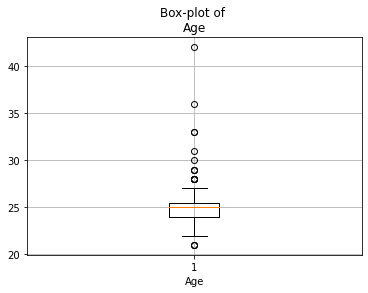

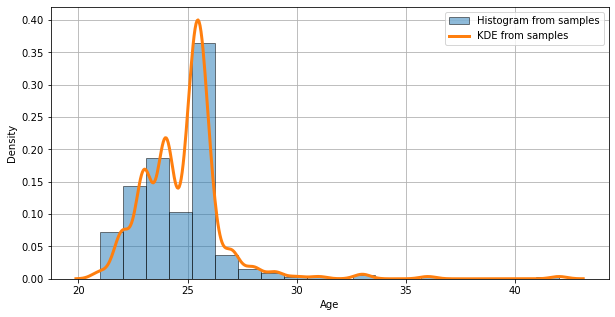

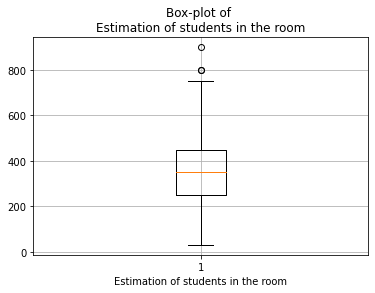

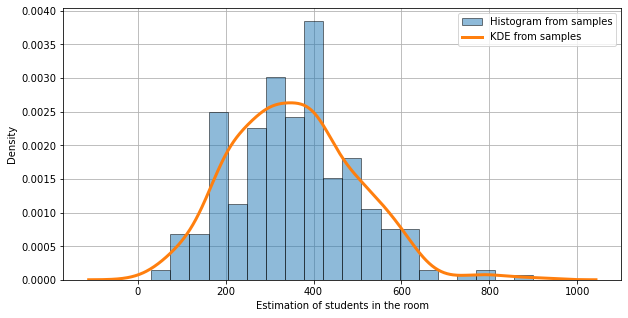

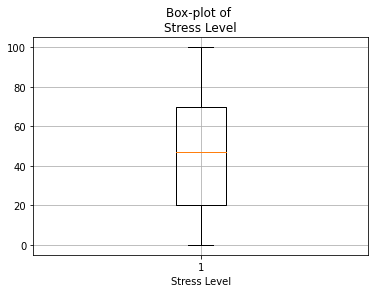

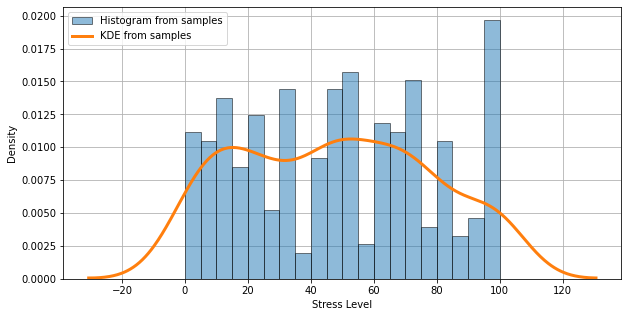

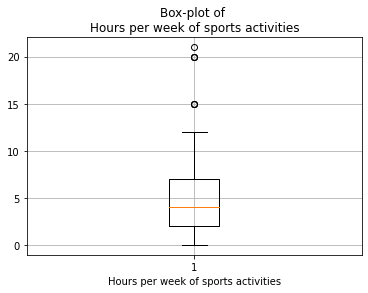

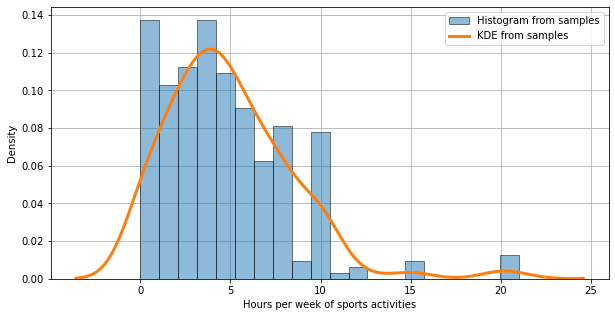

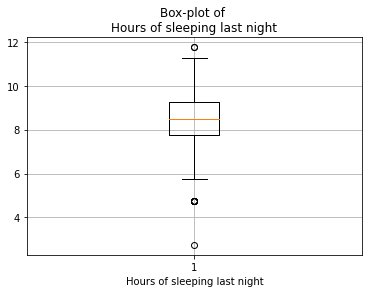

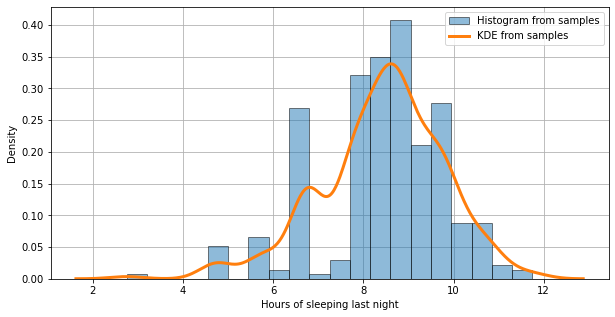

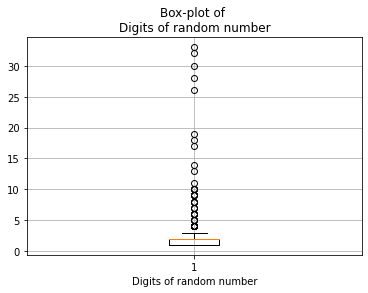

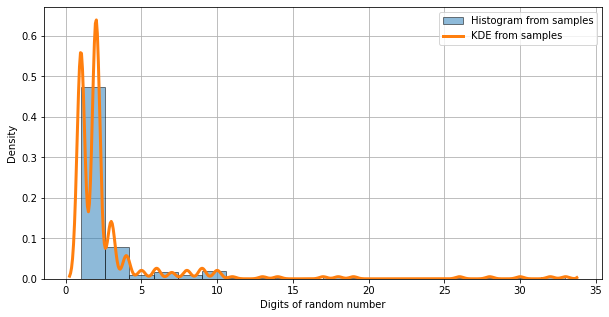

In [16]:
# Some more visulaisations of the data. 
# Box-plots of the numerical data, density plots and fitted distributions
cols = ['Age', 'Estimation of students in the room', 'Stress Level', 
        'Hours per week of sports activities', 'Hours of sleeping last night', 'Digits of random number']
for col in cols:
    plt.figure()
    plt.boxplot(df[col])
    plt.title(f'Box-plot of \n{col}')
    plt.xlabel(col)
    plt.grid(True)
    

    kde = sm.nonparametric.KDEUnivariate(df[col])
    kde.fit()  # Estimate the densities

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    # Plot the histrogram
    ax.hist(
        df[col],
        bins=20,
        density=True,
        label="Histogram from samples",
        zorder=5,
        edgecolor="k",
        alpha=0.5,
    )
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    # Plot the KDE as fitted using the default arguments
    ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)


    ax.legend(loc="best")
    ax.grid(True, zorder=-5)
    

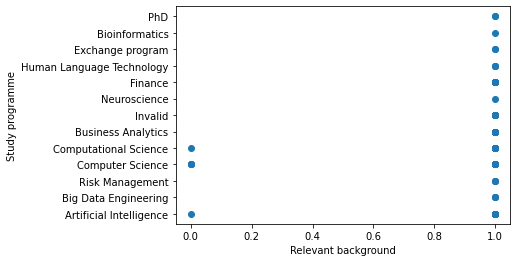

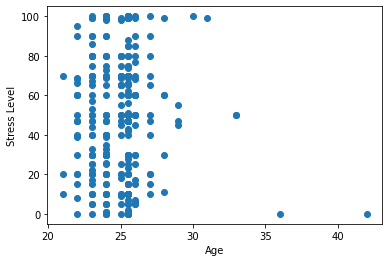

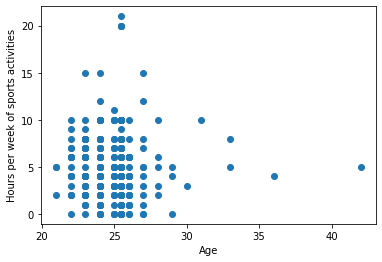

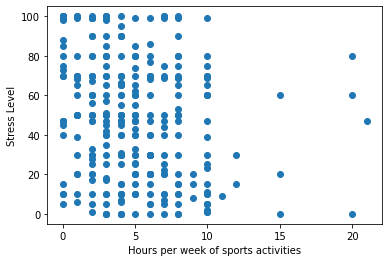

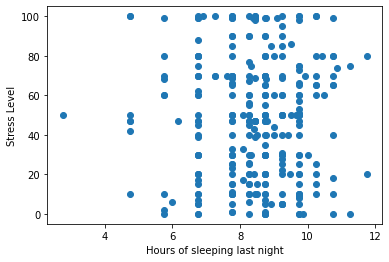

In [17]:
# SHow some of the relationships between features. No correlations between features
plt.scatter(df['Relevant background?'], df['Programme'])
plt.xlabel('Relevant background')
plt.ylabel('Study programme')
plt.figure()
plt.xlabel('Age')
plt.ylabel('Stress Level')
plt.scatter(df['Age'], df['Stress Level'])
plt.figure()
plt.xlabel('Age')
plt.ylabel('Hours per week of sports activities')
plt.scatter(df['Age'], df['Hours per week of sports activities'])
plt.figure()
plt.xlabel('Hours per week of sports activities')
plt.ylabel('Stress Level')
plt.scatter(df['Hours per week of sports activities'], df['Stress Level'])
plt.figure()
plt.ylabel('Stress Level')
plt.xlabel('Hours of sleeping last night')
plt.scatter(df['Hours of sleeping last night'], df['Stress Level'])

#download the cleaned data in a csv file 
df.to_csv(r'DataCleaned.csv')

## Find indices with continuous invalid answers
- Spot out unserious answers
- The procedure is to keep finding invalid indices per new column, adding this to a list
topic_invalid, and putting that list into input_lists below, that will spot out invalid answers

In [18]:
input_lists = [invalid_indices_sport, invalid_indices_stress, 
               invalid_indices_students_estimate, invalid_indices_bed_time,
              invalid_indices_random_number]

# Initialize an empty dictionary to store counts
counts = {}

# Loop through each input list
for lst in input_lists:
    # Loop through elements and update counts
    for element in lst:
        if element in counts:
            counts[element] += 1
        else:
            counts[element] = 1

            
print('Here are the amounts on unseriousness points from high to low out of %i columns'%(len(input_lists)))
# Sort the dictionary by values in descending order
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

df_invalid = pd.DataFrame(sorted_counts)
df_invalid.index = df_invalid.index + 1
df_invalid = df_invalid.head(10)
custom_column_names = ['Row index', 'Points']
df_invalid.columns = custom_column_names
display(HTML(df_invalid.to_html(index=True)))


for i in range(4):
    row_index = sorted_counts[i][0]
    count = sorted_counts[i][1]
    print(f'{i+1}. Person {row_index} gave {count}/{len(input_lists)} unserious answers: \n')
    print(df.iloc[row_index])
    print('\n')


Here are the amounts on unseriousness points from high to low out of 5 columns


,Row index,Points
1,262,4
2,12,3
3,302,3
4,189,3
5,250,3
6,254,3
7,86,2
8,268,2
9,21,1
10,236,1


1. Person 262 gave 4/5 unserious answers: 

Programme                                             Computer Science
Gender                                                            male
ChatGPT use in assignments                                         yes
Age                                                                 23
Estimation of students in the room                                 567
Did you stand up to come to your previous answer ?                  no
Stress Level                                                        47
Hours per week of sports activities                                  4
Hours of sleeping last night                                  8.433333
Good day for you 1                                        Good Weather
Digits of random number                                              2
Relevant background?                                                 1
Stress Level Discr.                                         Manageable
Name: 262, dtype: object


2. Per

In [19]:
# Beginning of the Classification method

#First of all, the values are pre-processed

#Dataframe with numerical values only
df_numerical = df
df_numerical.drop('Programme', axis=1, inplace=True)
df_numerical.drop('Gender', axis=1, inplace=True)
df_numerical.drop('ChatGPT use in assignments', axis=1, inplace=True)
df_numerical.drop('Did you stand up to come to your previous answer ?', axis=1, inplace=True)
df_numerical.drop('Good day for you 1', axis=1, inplace=True)

In [20]:
# print the numerical dataframe, containing only numerical values
df_numerical

,Age,Estimation of students in the room,Stress Level,Hours per week of sports activities,Hours of sleeping last night,Digits of random number,Relevant background?,Stress Level Discr.
0,26,319,100,0,9.250000,2,1,Very High
1,28,600,60,2,9.750000,2,0,Manageable
2,25.486239,220,20,5,9.250000,2,1,Manageable
3,27,100,50,5,9.750000,2,1,Manageable
4,25,300,65,10,9.750000,3,1,Manageable
5,23,500,80,5,8.750000,2,1,Very High
6,24,150,100,7,9.750000,2,1,Very High
7,23,600,30,4,8.750000,1,1,Manageable
8,27,525,65,5,10.250000,3,0,Manageable
9,25,570,70,6,8.750000,3,1,Manageable


Mean is [-1.11022302e-15 -1.90323947e-17  5.07530526e-17 -2.53765263e-16
  2.53765263e-17  2.09356342e-16], and the standard deviation is [1. 1. 1. 1. 1. 1.]
Mean is [-1.11022302e-15 -1.90323947e-17  5.07530526e-17 -2.53765263e-16
  2.53765263e-17  2.09356342e-16], and the standard deviation is [1.15135223 0.81130347 1.43216497 0.84939722 1.08874068 0.88406028]
Mean is [-5.05944493e-16  2.15700473e-16 -6.92567696e-17  3.34124263e-16
 -2.11471052e-18  3.54742690e-16], and the standard deviation is [1. 1. 1. 1. 1. 1.]
[0.23491753 0.21612056 0.16337054 0.14382869 0.12288576 0.11887693]
[14.0474454  13.47372523 11.71457436 10.99163775 10.159923    9.99282832]


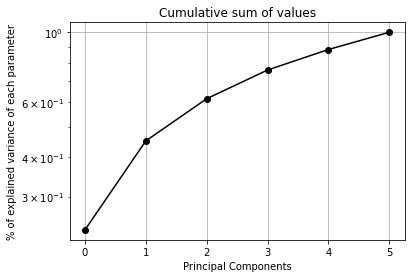

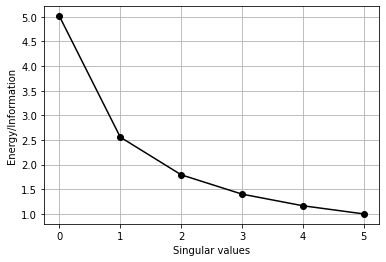

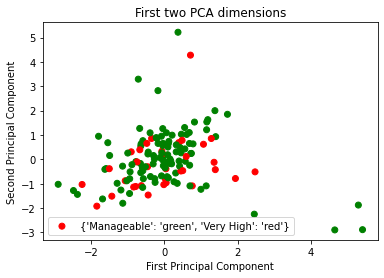

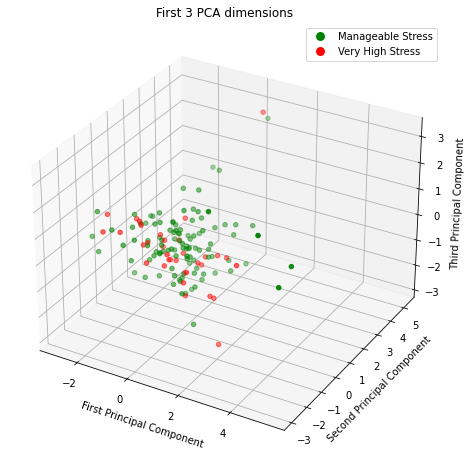

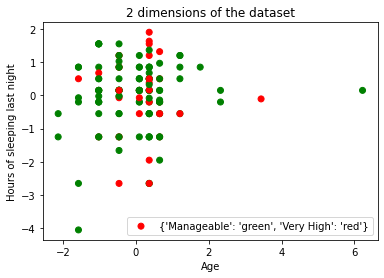

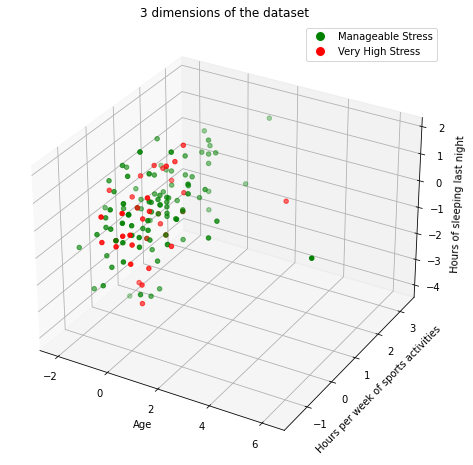

In [21]:
# Perform Principal Components Analysis - Investigate dimensionality reduction
from sklearn import preprocessing
from sklearn.decomposition import PCA
# Standardize the data - all on the same scale
# Scale the test and training set separately, not leak training data
numerical_data = df_numerical.iloc[:, :7]
numerical_data.drop('Stress Level', axis=1, inplace=True)
# Split the set in training, validation and test set 
training_set = numerical_data.iloc[:140, :]
valid_set = numerical_data.iloc[140:200, :]
test_set = numerical_data.iloc[200:, :]
# final sets, for the evaluation of the algorithms 
X_final = numerical_data.iloc[:200, :]
y_final = df_numerical['Stress Level Discr.'][:200]

#Scale the subsets of the data separately
scaler_train = preprocessing.StandardScaler().fit(training_set)
scaled_train = scaler_train.transform(training_set)
print(f"Mean is {scaled_train.mean(axis=0)}, and the standard deviation is {scaled_train.std(axis=0)}")
scaler_valid = preprocessing.StandardScaler().fit(valid_set)
scaled_valid = scaler_train.transform(valid_set)
print(f"Mean is {scaled_train.mean(axis=0)}, and the standard deviation is {scaled_valid.std(axis=0)}")
scaler_test = preprocessing.StandardScaler().fit(test_set)
scaled_test = scaler_test.transform(test_set)
print(f"Mean is {scaled_test.mean(axis=0)}, and the standard deviation is {scaled_test.std(axis=0)}")


# PCA to the training set
def PrincipalComp(desired_comp, pca_scaled_train):
    pca = PCA(n_components = desired_comp)
    pca.fit(pca_scaled_train)
    data = pca.transform(pca_scaled_train)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)
    # plot the scaled data and the principal components

    cumulative = np.cumsum(pca.explained_variance_ratio_)
    plt.semilogy(cumulative, '-o', color='black')
    plt.xlabel('Principal Components')
    plt.ylabel('% of explained variance of each parameter')
    plt.title('Cumulative sum of values')
    plt.grid(True)
    plt.show()
    plt.figure()
    plt.plot(np.sum(pca.singular_values_)/np.cumsum(pca.singular_values_), '-o', color='k')
    plt.xlabel('Singular values')
    plt.ylabel('Energy/Information')
    plt.grid(True)
    plt.show()
    def plot_data(datapoints, pca = False):
    # map the different stress categories into colours
        colors = {'Manageable':'green', 'Very High':'red'}
        global colormap
        colormap = np.array([colors[a] for a in df_numerical['Stress Level Discr.']])
        if pca:
            # Create the scatter plot with the colormap - 2 dimensions
            plt.scatter(datapoints[:, 0], datapoints[:, 1], c=colormap[:140], label = colors)
            plt.xlabel('First Principal Component')
            plt.ylabel('Second Principal Component')
            plt.title('First two PCA dimensions')
            plt.legend(loc='best')
            plt.show()
            fig = plt.figure(figsize = (10,8))
            # 3 - dimensions
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(datapoints[:, 0], datapoints[:, 1], datapoints[:, 2], c = colormap[:140])
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')
            ax.set_title('First 3 PCA dimensions')
            ax.set_zlabel('Third Principal Component')
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Manageable Stress',
                                  markerfacecolor=colors['Manageable'], markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', label='Very High Stress',
                                  markerfacecolor=colors['Very High'], markersize=10)]
            ax.legend(handles=legend_elements)
            plt.show()
        else:
            plt.scatter(datapoints[:, 0], datapoints[:, 3], c=colormap[:140], label = colors)
            plt.xlabel('Age')
            plt.ylabel('Hours of sleeping last night')
            plt.title('2 dimensions of the dataset')
            plt.legend(loc='best')
            plt.show()                

            fig = plt.figure(figsize = (10,8))
            # 3 - dimensions
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(datapoints[:, 0], datapoints[:, 2], datapoints[:, 3], c = colormap[:140])
            ax.set_xlabel('Age')
            ax.set_title('3 dimensions of the dataset')
            ax.set_ylabel('Hours per week of sports activities')
            ax.set_zlabel('Hours of sleeping last night')
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Manageable Stress',
                                  markerfacecolor=colors['Manageable'], markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', label='Very High Stress',
                                  markerfacecolor=colors['Very High'], markersize=10)]
            ax.legend(handles=legend_elements)
            plt.show()
            
    plot_data(data, pca = True)
    plot_data(pca_scaled_train)
    data = pd.DataFrame(data)
    return data

data_svm_pca = PrincipalComp(len(training_set.columns),scaled_train)

In [22]:
def Classification(hyperparameter, train, valid):
    #Function that performs the SVM classification algorithm in the dataset.
    lin_clf = svm.SVC(C=hyperparameter)
    lin_clf.fit(pd.DataFrame(train), df_numerical['Stress Level Discr.'][:140])
    #Print the accuracy of the classification algorithm, tested on the test data
    y_pred = lin_clf.predict(pd.DataFrame(valid))
    accuracy = accuracy_score(df_numerical['Stress Level Discr.'][140:200], y_pred)    
    return accuracy
    
# Tune the hyperparameters in the validation set 
hyperparams = [0.01, 0.1, 1, 5, 20, 100, 1000]
dataset = [data_svm_pca, scaled_train]
acc_results = {}
for i, data in enumerate(dataset):
    acc_results[f"Dataset {i}"] = {}
    if i == 0:
        # Perform the PCA also in the test set
        pca = PCA(n_components = len(data_svm_pca.columns))
        pca.fit(scaled_valid)
        data_pca_valid = pca.transform(scaled_valid)
        data_pca_valid = pd.DataFrame(data_pca_valid)
        
        for param in hyperparams:
            # Data with PCA
            result = Classification(param, data, data_pca_valid)
            acc_results[f"Dataset {i}"][f"C = {param}"] = result
    else:
        # Scaled data without PCA
        for param in hyperparams:
            result = Classification(param, data, scaled_valid)
            acc_results[f"Dataset {i}"][f"C = {param}"] = result

acc_results

{'Dataset 0': {'C = 0.01': 0.7666666666666667,
  'C = 0.1': 0.7666666666666667,
  'C = 1': 0.7666666666666667,
  'C = 5': 0.7666666666666667,
  'C = 20': 0.7166666666666667,
  'C = 100': 0.6,
  'C = 1000': 0.55},
 'Dataset 1': {'C = 0.01': 0.7666666666666667,
  'C = 0.1': 0.7666666666666667,
  'C = 1': 0.7666666666666667,
  'C = 5': 0.7833333333333333,
  'C = 20': 0.7333333333333333,
  'C = 100': 0.6333333333333333,
  'C = 1000': 0.6}}

Final accuracy with the SVM algorithm, tested on the test set:0.8285714285714286
95% Confidence interval of the accuracy: (0.7564825944845882, 0.900660262658269)
Area under the ROC curve is: 0.6128015350877194


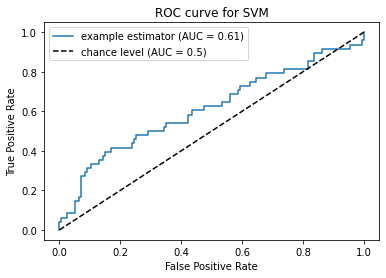

In [23]:
def AUC(score, pos_label, title):
    fpr, tpr, thresholds = metrics.roc_curve(df_numerical['Stress Level Discr.'][:200],score, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.legend()
    plt.title(title)
    plt.show()

# Apply the SVM algorithm with the optimised hyperparameters to the test data
lin_clf = svm.SVC(C=5, probability = True)
lin_clf.fit(pd.DataFrame(X_final), df_numerical['Stress Level Discr.'][:200])
#Print the accuracy of the classification algorithm, tested on the test data
y_pred = lin_clf.predict(pd.DataFrame(scaled_test))
accuracy_svm = accuracy_score(df_numerical['Stress Level Discr.'][200:], y_pred)
ci = (accuracy_svm -1.96*np.sqrt((1/len(scaled_test))*accuracy_svm*(1-accuracy_svm)), accuracy_svm +1.96*np.sqrt((1/len(scaled_test))*accuracy_svm*(1-accuracy_svm)))
print(f"Final accuracy with the SVM algorithm, tested on the test set:{accuracy_svm}")
print(f"95% Confidence interval of the accuracy: {ci}")
confusion_matrix(df_numerical['Stress Level Discr.'][200:], y_pred)
roc_area = roc_auc_score(np.array(df_numerical['Stress Level Discr.'][:200]), lin_clf.predict_proba(X_final)[:, 1])
print(f"Area under the ROC curve is: {roc_area}")

AUC(lin_clf.predict_proba(X_final)[:, 1], pos_label = 'Very High', title='ROC curve for SVM')

Final accuracy of the Naive Bayes algorithm, tested on the test set: 0.819047619047619
95% Confidence interval of the accuracy: (0.7454102694262532, 0.8926849686689848)
Area under the ROC curve is: 0.6600877192982456


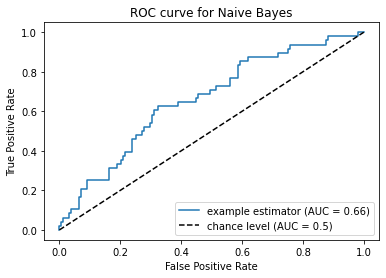

In [24]:
# Naive Bayes Classification
# Split: 2/3 training set and 1/3 test set 
gnb = GaussianNB()
y_pred = gnb.fit(numerical_data.iloc[:,:7][:200], df['Stress Level Discr.'][:200]).predict(numerical_data.iloc[:,:7][200:])
accuracy_nb = accuracy_score(df['Stress Level Discr.'][200:], y_pred)
ci = (accuracy_nb -1.96*np.sqrt((1/len(scaled_test))*accuracy_nb*(1-accuracy_nb)), accuracy_nb +1.96*np.sqrt((1/len(scaled_test))*accuracy_nb*(1-accuracy_nb)))
print(f"Final accuracy of the Naive Bayes algorithm, tested on the test set: {accuracy_nb}")
print(f"95% Confidence interval of the accuracy: {ci}")
confusion_matrix(df_numerical['Stress Level Discr.'][200:], y_pred)
roc_area = roc_auc_score(np.array(df_numerical['Stress Level Discr.'][:200]), gnb.predict_proba(X_final)[:, 1])
print(f"Area under the ROC curve is: {roc_area}")

AUC(gnb.predict_proba(X_final)[:, 1], pos_label='Very High', title = 'ROC curve for Naive Bayes')

In [25]:
# Classification using Neural Networks. Multi-Layer perceptron architecture
activ = ['identity', 'tanh', 'logistic', 'relu']
activ_result = {}

X = scaled_train
y = df_numerical['Stress Level Discr.'][:140]
for i in activ:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(6,2), random_state=1, activation = i)

    clf.fit(X, y)
    y_pred = clf.predict(scaled_valid)
    accuracy = accuracy_score(df_numerical['Stress Level Discr.'][140:200], y_pred) 
    activ_result[i] = accuracy

print(f"Different activation functions:\n{activ_result}")
# Tune the hyperparameters
architecture_result = {}
hidden_neurons = [(2,2,2), (6,6), (6,2), (4,3), (4,4), (2,3,4,5), (5,3), (2,6), 2, (4,4,3,2,5)]
for arch in hidden_neurons:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=arch, random_state=1, activation = 'relu')

    clf.fit(X, y)
    y_pred = clf.predict(scaled_valid)
    accuracy = accuracy_score(df_numerical['Stress Level Discr.'][140:200], y_pred) 
    architecture_result[arch] = accuracy
    
print(f"Tune the number of hidden layers and nodes:/n{architecture_result}")
activ_result


Different activation functions:
{'identity': 0.75, 'tanh': 0.6833333333333333, 'logistic': 0.6166666666666667, 'relu': 0.7666666666666667}
Tune the number of hidden layers and nodes:/n{(2, 2, 2): 0.7166666666666667, (6, 6): 0.6, (6, 2): 0.7666666666666667, (4, 3): 0.75, (4, 4): 0.6833333333333333, (2, 3, 4, 5): 0.7666666666666667, (5, 3): 0.7666666666666667, (2, 6): 0.7666666666666667, 2: 0.7666666666666667, (4, 4, 3, 2, 5): 0.7666666666666667}


{'identity': 0.75,
 'tanh': 0.6833333333333333,
 'logistic': 0.6166666666666667,
 'relu': 0.7666666666666667}

In [26]:
# print the results of the tuning of the neural network structure.
architecture_result

{(2, 2, 2): 0.7166666666666667,
 (6, 6): 0.6,
 (6, 2): 0.7666666666666667,
 (4, 3): 0.75,
 (4, 4): 0.6833333333333333,
 (2, 3, 4, 5): 0.7666666666666667,
 (5, 3): 0.7666666666666667,
 (2, 6): 0.7666666666666667,
 2: 0.7666666666666667,
 (4, 4, 3, 2, 5): 0.7666666666666667}

Final accuracy of the Neural Networks algorithm, tested on the test set: 0.8285714285714286
95% Confidence interval of the accuracy: (0.7564825944845882, 0.900660262658269)
Area under the ROC curve is: 0.5


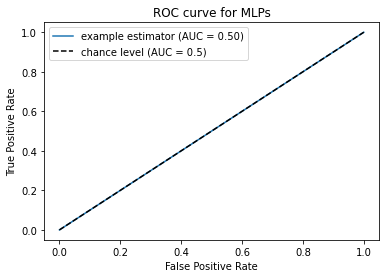

In [27]:
# Apply the Neural Networks algorithm with the optimised hyperparameters to the test data
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(6, 2), random_state=1, activation = 'relu')


clf.fit(X_final, y_final)
y_pred = clf.predict(scaled_test)
accuracy_nl = accuracy_score(df_numerical['Stress Level Discr.'][200:], y_pred) 
ci = (accuracy_nl -1.96*np.sqrt((1/len(scaled_test))*accuracy_nl*(1-accuracy_nl)), accuracy_nl+1.96*np.sqrt((1/len(scaled_test))*accuracy_nl*(1-accuracy_nl)))
print(f"Final accuracy of the Neural Networks algorithm, tested on the test set: {accuracy_nl}")
print(f"95% Confidence interval of the accuracy: {ci}")
confusion_matrix(df_numerical['Stress Level Discr.'][200:], y_pred)
roc_area = roc_auc_score(np.array(df_numerical['Stress Level Discr.'][:200]), clf.predict_proba(X_final)[:, 1])
print(f"Area under the ROC curve is: {roc_area}")
AUC(clf.predict_proba(X_final)[:, 1], pos_label = 'Very High', title = 'ROC curve for MLPs')

# Regression: numerical prediction task


Linear regression for Hours of sleep vs Stress level


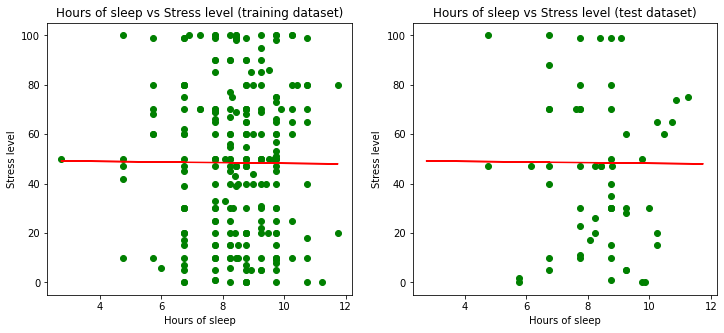

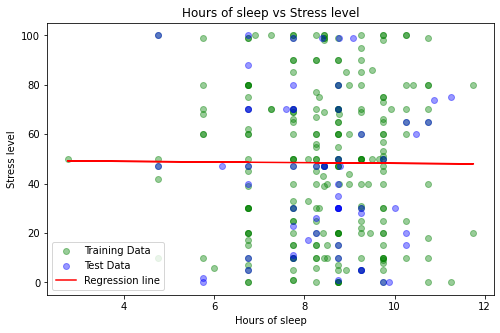

Details about the model
- Slope of the regression line is: -0.1312034418716816
- r^2 = -0.020676371097574142
- MSE = 919.693871242335
- MAE = 25.683462683425372

 

Linear regression for Hours of sport per week vs Stress level


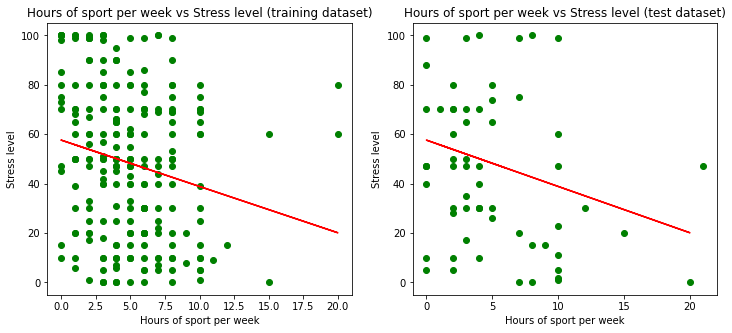

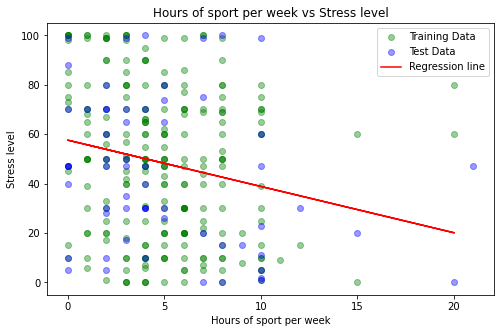

Details about the model
- Slope of the regression line is: -1.8752996744998927
- r^2 = 0.04821526246350605
- MSE = 857.6181585481481
- MAE = 25.171395334743437

 

Linear regression for Age vs Stress level


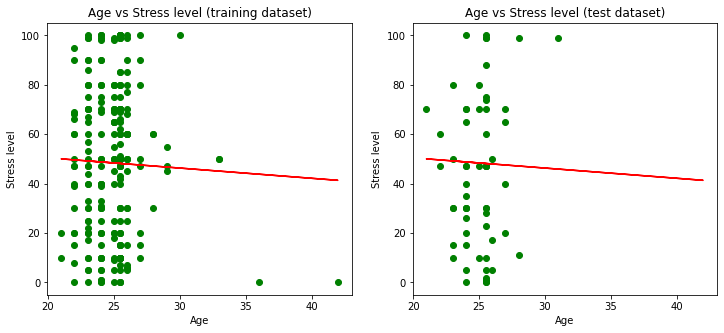

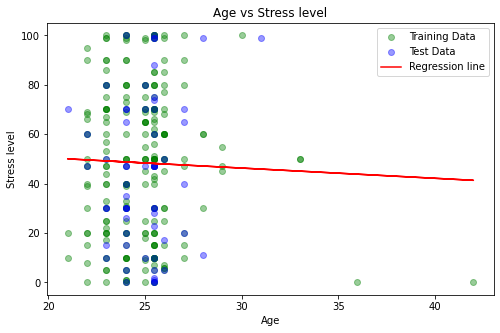

Details about the model
- Slope of the regression line is: -0.41333739396248886
- r^2 = -0.02725686091116475
- MSE = 925.6233081556474
- MAE = 25.713843829942483

 

Linear regression for Estimation of students in the room vs Stress level


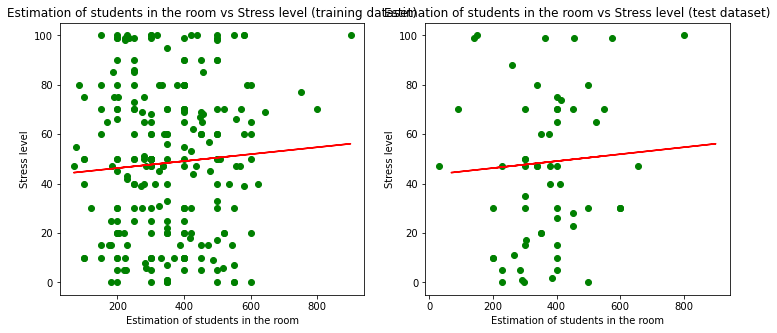

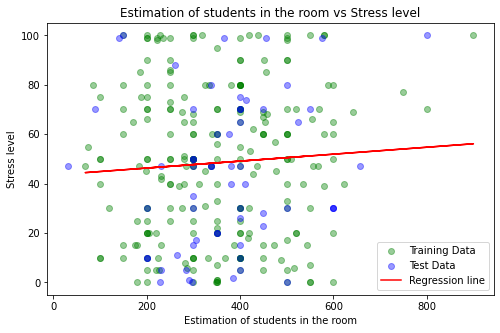

Details about the model
- Slope of the regression line is: 0.014048174104013145
- r^2 = -0.008606606024005314
- MSE = 908.8182506442414
- MAE = 25.664712753360877

 

Linear regression for Digits of random number vs Stress level


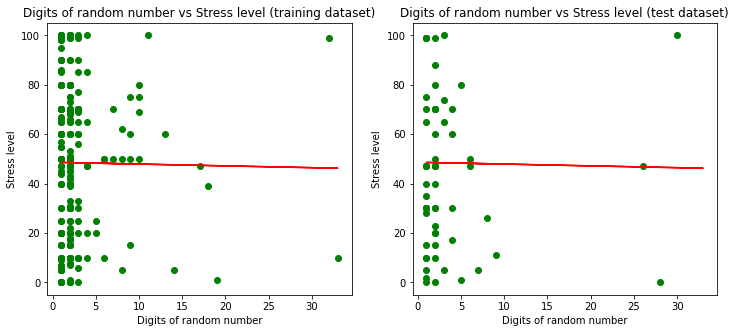

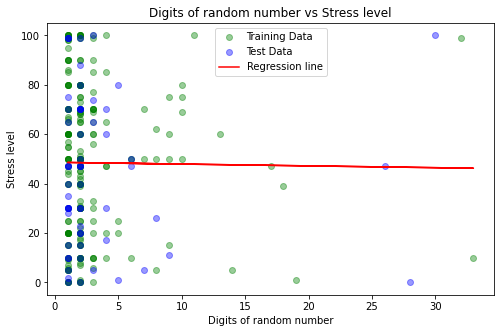

Details about the model
- Slope of the regression line is: -0.07279720311307208
- r^2 = -0.02117711013625101
- MSE = 920.1450687403897
- MAE = 25.65275667508766

 



x-data name,Slope,$r^{2}$,MSE,MAE
Hours of sleep,-0.131203,-0.020676,919.693871,25.683463
Hours of sport per week,-1.875300,0.048215,857.618159,25.171395
Age,-0.413337,-0.027257,925.623308,25.713844
Estimation of students in the room,0.014048,-0.008607,908.818251,25.664713
Digits of random number,-0.072797,-0.021177,920.145069,25.652757


\begin{tabular}{lrrrr}
\toprule
                       x-data name &     Slope &   \$r\textasciicircum \{2\}\$ &        MSE &       MAE \\
\midrule
                    Hours of sleep & -0.131203 & -0.020676 & 919.693871 & 25.683463 \\
           Hours of sport per week & -1.875300 &  0.048215 & 857.618159 & 25.171395 \\
                               Age & -0.413337 & -0.027257 & 925.623308 & 25.713844 \\
Estimation of students in the room &  0.014048 & -0.008607 & 908.818251 & 25.664713 \\
           Digits of random number & -0.072797 & -0.021177 & 920.145069 & 25.652757 \\
\bottomrule
\end{tabular}

Accuracy: 4.13%


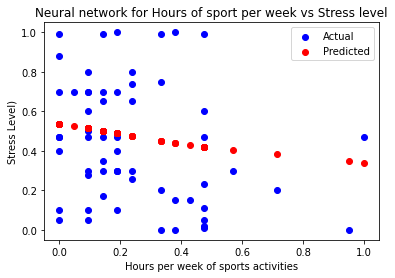

Accuracy: -5.04%


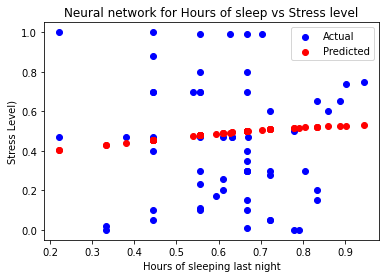

Accuracy: -3.96%


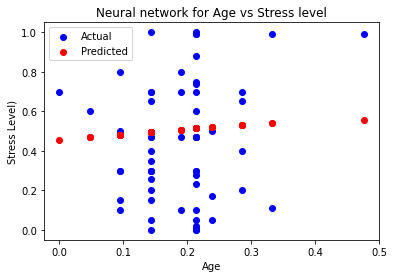

Accuracy: -2.52%


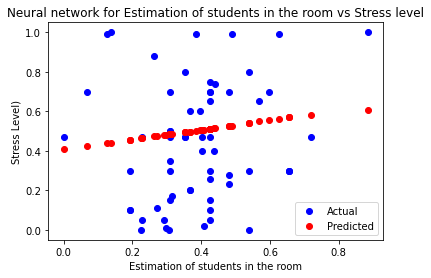

Accuracy: -6.89%


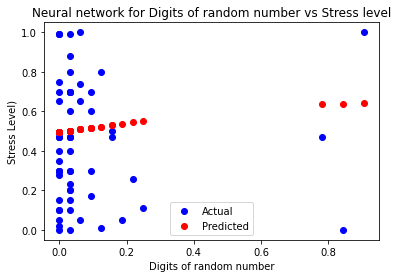

In [28]:
df = pd.DataFrame(classroom)

def impute_column_by_mean(column_name, max_value):
    df[column_name] = df[column_name].where(df[column_name] <= max_value, np.nan)
    mean_value = df[column_name].mean(skipna=True)
    df[column_name].fillna(mean_value, inplace=True)
    
def impute_column_by_median(column_name, max_value):
    df[column_name] = df[column_name].where(df[column_name] <= max_value, np.nan)
    median_value = df[column_name].median(skipna=True)
    df[column_name].fillna(median_value, inplace=True)
    
def impute_column_replace_value(column_name, old_value, new_value):
    if isinstance(old_value, list) and isinstance(new_value, list):
        value_map = dict(zip(old_value, new_value))
        df[column_name] = df[column_name].replace(value_map)
    elif isinstance(old_value, list)==True and isinstance(new_value, list)==False:
        for old in old_value:
            df[column_name] = df[column_name].replace(old, new_value)
    else:
        df[column_name] = df[column_name].replace(old_value, new_value)


# Remove everybody over 100 years old, and replace by mean age
impute_column_by_mean('Age', 100)
# Replace discrete stress levels low, medium, and high, by numerical value, 0,1 and 2 respectively
impute_column_replace_value('Stress Level Discr.', ['Low', 'Medium', 'High'], [0,1,2])

def linear_regression_algorithm(column_name, plot_title=None):
    x = df[column_name].values
    y = df['Stress Level'].values

    # Min-max scaling for the input feature, uncomment following line if needed
    # x = (x - np.min(x)) / (np.max(x) - np.min(x))
    # y = (y - np.min(y)) / (np.max(y) - np.min(y))

    if plot_title == None:
        plot_title = column_name
        
    # Reshape x to a 2D array
    x = x.reshape(-1, 1)

    x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 1/5, random_state=0)  

    regressor= LinearRegression()  
    regressor.fit(x_train, y_train) 

    #Prediction of Test and Training set result  
    y_pred= regressor.predict(x_test)  
    x_pred = regressor.predict(x_train)
    # Details of the fit
    slope = regressor.coef_[0]
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Linear regression for {plot_title} vs Stress level")

    # Creating subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for training dataset
    axs[0].scatter(x_train, y_train, color="green")
    axs[0].plot(x_train, x_pred, color="red")
    axs[0].set_title(f"{plot_title} vs Stress level (training dataset)")
    axs[0].set_xlabel(f"{plot_title}")
    axs[0].set_ylabel("Stress level")

    # Plot for test dataset
    axs[1].scatter(x_test, y_test, color="green")
    axs[1].plot(x_train, x_pred, color="red")
    axs[1].set_title(f"{plot_title} vs Stress level (test dataset)")
    axs[1].set_xlabel(f"{plot_title}")
    axs[1].set_ylabel("Stress level")

    plt.show()

    plt.figure(figsize=(8,5))
    plt.scatter(x_train, y_train, color="green", alpha=0.4, label='Training Data') 
    plt.scatter(x_test, y_test, color="blue", alpha=0.4, label='Test Data')   
    plt.plot(x_train, x_pred, color="red", label='Regression line')    
    plt.title(f"{plot_title} vs Stress level")  
    plt.xlabel(f"{plot_title}")  
    plt.ylabel("Stress level")  
    plt.legend()
    #plt.savefig(f'Downloads/{plot_title}-stress.png', dpi=200)
    plt.show()
    
    print('Details about the model')
    print(f'- Slope of the regression line is: {slope}')
    print(f"- r^2 = {r2}")
    print(f'- MSE = {mse}')
    print(f'- MAE = {mae}')

    print("\n \n")
    
    return plot_title, slope, r2, mse, mae
    
def neural_network_algorithm(column_name, plot_title=None):
    # Extract the feature column and target column
    x = df[column_name].values.reshape(-1, 1)
    y = df['Stress Level'].values

    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    y_test_bin = [1 if val > 0.5 else 0 for val in y_test]

    if plot_title == None:
        plot_title = column_name
        
    # Create an instance of MLPRegressor with hidden layer sizes and activation function
    clf = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=0)

    # Fit the regressor to the training data
    clf.fit(x_train, y_train)

    # Predict the stress levels for the test data
    y_pred = clf.predict(x_test)
    y_pred_bin = [1 if val > 0.5 else 0 for val in y_pred]

    # Calculate the accuracy of the model
    accuracy = clf.score(x_test, y_test)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    plt.title(f"Neural network for {plot_title} vs Stress level")  

    plt.scatter(x_test, y_test, color='blue', label='Actual')
    plt.scatter(x_test, y_pred, color='red', label='Predicted')

    plt.xlabel(column_name)
    plt.ylabel('Stress Level)')
    plt.legend()
    plt.show()

    
linear_regression_dict = {}
plot_list = []
slope_list = []
r2_list = []
mse_list = []
mae_list = []

plot_name, slope, r2, mse, mae = linear_regression_algorithm('Hours of sleeping last night', 'Hours of sleep')
plot_list.append(plot_name)
slope_list.append(slope)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)

plot_name, slope, r2, mse, mae = linear_regression_algorithm('Hours per week of sports activities', 'Hours of sport per week')
plot_list.append(plot_name)
slope_list.append(slope)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)

plot_name, slope, r2, mse, mae = linear_regression_algorithm('Age')
plot_list.append(plot_name)
slope_list.append(slope)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)

plot_name, slope, r2, mse, mae = linear_regression_algorithm('Estimation of students in the room')
plot_list.append(plot_name)
slope_list.append(slope)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)


plot_name, slope, r2, mse, mae = linear_regression_algorithm('Digits of random number')
plot_list.append(plot_name)
slope_list.append(slope)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)

linear_regression_dict['x-data name'] = plot_list
linear_regression_dict['Slope'] = slope_list
linear_regression_dict[r'$r^{2}$'] = r2_list
linear_regression_dict['MSE'] = mse_list
linear_regression_dict['MAE'] = mae_list

df_LR = pd.DataFrame(linear_regression_dict)
# df_LR.index = df_LR.index + 1
display(HTML(df_LR.to_html(index=False)))

table = df_LR.to_latex(index=False)
print(table)



neural_network_algorithm('Hours per week of sports activities', 'Hours of sport per week')
neural_network_algorithm('Hours of sleeping last night', 'Hours of sleep')
neural_network_algorithm('Age')
neural_network_algorithm('Estimation of students in the room')
neural_network_algorithm('Digits of random number')

